# **Memory Access Latency TEST**

**Importing necessary Libraries**

In [ ]:
import argparse
import numpy as np
import threading
import time
import itertools
import matplotlib.pyplot as plt

**SETTING DEFAULT VALUES**

In [ ]:
DEFAULT_ACCESSES = 10000000
DEFAULT_STRIDE = 512
DEFAULT_CACHE_LINE_SIZE = 64
MIN_SIZE = 512
DEFAULT_MAX_SIZE = 1024 * 1024 * 1024

**SOME COMMANDS IF USING COMMAMND LINE**

In [ ]:
def parse_arguments():
    parser = argparse.ArgumentParser(description="Memory Access Latency Test")
    parser.add_argument("-l", "--line-size", type=int, default=DEFAULT_CACHE_LINE_SIZE, help="Size of a cache line in B")
    parser.add_argument("-a", "--accesses", type=int, default=DEFAULT_ACCESSES, help="Number of memory accesses")
    parser.add_argument("-s", "--stride", type=int, default=DEFAULT_STRIDE, help="Stride between accesses in B")
    parser.add_argument("-m", "--max-size", type=int, default=DEFAULT_MAX_SIZE, help="Maximum memory size in bytes")
    parser.add_argument("-f", "--forward", action="store_true", help="Use forward memory scan")
    parser.add_argument("-i", "--index", action="store_true", help="Use index-based memory scan")
    parser.add_argument("-c", "--concurrent", action="store_true", help="Run test on two threads")
    return parser.parse_args()

In [ ]:
def warmup_memory(mem):
    _ = np.sum(mem)  # Touch every element to ensure it is in cache

In [ ]:
def compute_forward_pointers(mem, stride, line_size):
    size = len(mem)
    for i in range(0, size - stride, line_size):
        mem[i] = i + stride
    for i in range(size - stride, size, line_size):
        mem[i] = (i + line_size) % stride

In [ ]:
def compute_backward_pointers(mem, stride, line_size):
    size = len(mem)
    for i in range(0, size - stride, line_size):
        mem[i + stride] = i
    for i in range(size - stride, size, line_size):
        mem[(i + line_size) % stride] = i

In [ ]:
def pointer_scan(mem, accesses):
    ptr = 0
    start = time.perf_counter()
    for _ in range(accesses):
        ptr = mem[ptr]
    end = time.perf_counter()
    return (end - start) * 1e9 / accesses  # Convert seconds to nanoseconds

In [ ]:
def index_scan(mem, stride, accesses):
    total = 0
    start = time.perf_counter()
    for _ in range(accesses):
        for i in range(0, len(mem), stride):
            total += mem[i]
    end = time.perf_counter()
    return (end - start) * 1e9 / accesses

In [ ]:
def scan(mem, stride, line_size, accesses, forward, index_based):
    if not index_based:
        if forward:
            compute_forward_pointers(mem, stride, line_size)
        else:
            compute_backward_pointers(mem, stride, line_size)
    return index_scan(mem, stride, accesses) if index_based else pointer_scan(mem, accesses)

In [ ]:
# Function to run the test and store results
def run_test(id, args, results):
    mem = np.zeros(args.max_size // 8, dtype=np.int64)  # Simulate memory with an array
    warmup_memory(mem)

    size = max(MIN_SIZE, args.stride)
    while size <= args.max_size:
        latency = scan(mem, args.stride, args.line_size, args.accesses, args.forward, args.index)
        print(f"{id}, {size / (1024 * 1024):.5f}, {latency:.3f}")
        results.append((size / (1024 * 1024), latency))  # Store size in MiB and latency
        size = ((size * 2) if size < 1024 else size + 1024)  # Mimic step function

In [ ]:
def run_and_store_results(args, results_dict, label):
    results = []
    run_test(0, args, results)  # Run on main thread
    results_dict[label] = results  # Store results

In [ ]:

# Function to plot results with multiple configurations
def plot_results(results_dict):
    plt.figure(figsize=(12, 7))

    for label, results in results_dict.items():
        sizes, latencies = zip(*results)
        plt.plot(sizes, latencies, marker='o', linestyle='-', label=label)

    # Log scale for better visualization
    plt.xscale('log')

    # Cache markers
    cache_sizes = [32 / 1024, 1, 13.75]  # L1: 32 KiB, L2: 1 MiB, L3: 13.75 MiB
    cache_labels = ["L1 cache\n(32 KiB)", "L2 cache\n(1 MiB)", "L3 cache\n(13.75 MiB)"]
    for size, label in zip(cache_sizes, cache_labels):
        plt.axvline(x=size, color='red', linestyle='dashed', linewidth=2)
        plt.text(size, 70, label, color='red', fontsize=10, ha='center')

    # Labels, title, and legend
    plt.xlabel("Memory Size (MiB)")
    plt.ylabel("Access Latency (ns)")
    plt.title("Memory Access Latency for Different Strides, Threads, and Scans")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.show()

In [ ]:
# Main function to test multiple configurations
def main():
    # Define test parameter ranges
    strides = [128, 256]
    scan_types = [(True, False), (True, True), (False, False), (False, True)]  # (forward, index)
    threads = [False, True]  # Single-thread and Concurrent

    results_dict = {}

    # Iterate over all parameter combinations
    for stride, (forward, index), concurrent in itertools.product(strides, scan_types, threads):
        args = argparse.Namespace(
            line_size=64,
            accesses=100,  # Reduced for testing speed
            stride=stride,
            max_size=1*1024*1024,  # Test up to 16 MiB
            forward=forward,
            index=index,
            concurrent=concurrent
        )

        label = f"{'Fwd' if forward else 'Bwd'} {'Idx' if index else 'Ptr'} - {'2T' if concurrent else '1T'} - Stride {stride}"
        print(f"Running {label}...")

        if concurrent:
            thread = threading.Thread(target=run_and_store_results, args=(args, results_dict, label))
            thread.start()
            thread.join()

        run_and_store_results(args, results_dict, label)

    print("All tests completed! Generating plots...")
    plot_results(results_dict)

Streaming output truncated to the last 5000 lines.
0, 0.12500, 169.900
0, 0.12598, 127.100
0, 0.12695, 126.740
0, 0.12793, 127.670
0, 0.12891, 178.190
0, 0.12988, 127.300
0, 0.13086, 124.730
0, 0.13184, 127.740
0, 0.13281, 126.760
0, 0.13379, 128.870
0, 0.13477, 127.090
0, 0.13574, 128.290
0, 0.13672, 127.190
0, 0.13770, 128.820
0, 0.13867, 128.860
0, 0.13965, 129.540
0, 0.14062, 126.830
0, 0.14160, 127.700
0, 0.14258, 127.590
0, 0.14355, 128.570
0, 0.14453, 127.980
0, 0.14551, 128.690
0, 0.14648, 127.610
0, 0.14746, 133.500
0, 0.14844, 129.640
0, 0.14941, 128.950
0, 0.15039, 126.920
0, 0.15137, 128.190
0, 0.15234, 127.090
0, 0.15332, 123.000
0, 0.15430, 122.900
0, 0.15527, 177.100
0, 0.15625, 140.030
0, 0.15723, 128.310
0, 0.15820, 126.710
0, 0.15918, 127.750
0, 0.16016, 128.170
0, 0.16113, 127.330
0, 0.16211, 125.550
0, 0.16309, 128.570
0, 0.16406, 126.980
0, 0.16504, 133.430
0, 0.16602, 128.590
0, 0.16699, 125.050
0, 0.16797, 123.580
0, 0.16895, 122.910
0, 0.16992, 124.240
0, 0.1709

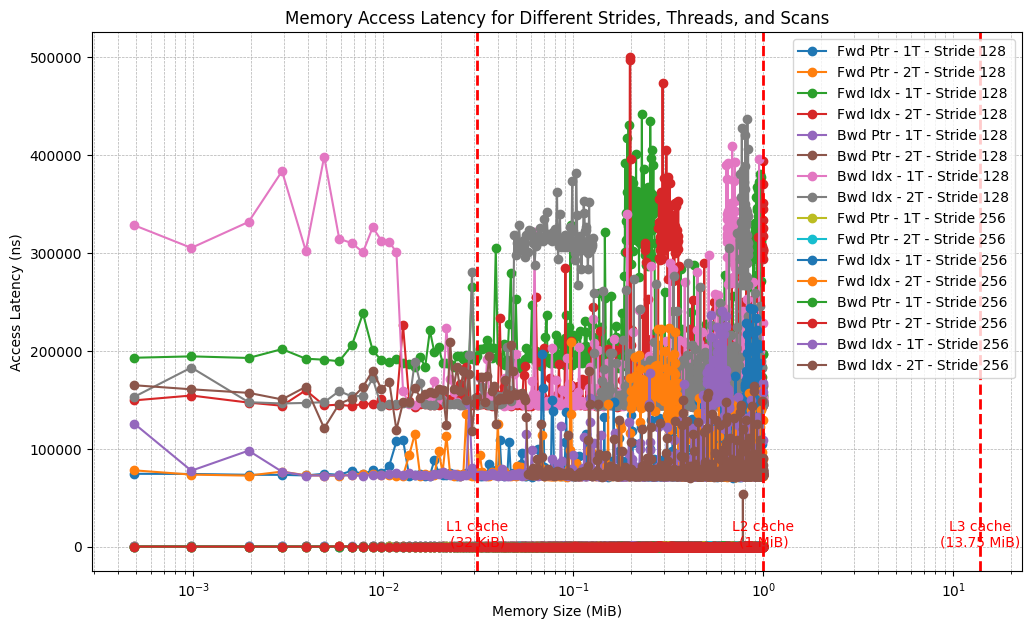

In [ ]:
if __name__ == "__main__":
    main()

In [ ]:





# # Function to plot the results
# def plot_results(results1, results2=None):
#     plt.figure(figsize=(10, 6))

#     # Convert stored results into lists
#     sizes1, latencies1 = zip(*results1)

#     # Plot first thread results
#     plt.plot(sizes1, latencies1, marker='o', linestyle='-', label="Thread 0")

#     # If second thread results exist, plot them
#     if results2:
#         sizes2, latencies2 = zip(*results2)
#         plt.plot(sizes2, latencies2, marker='s', linestyle='--', label="Thread 1")

#     # Labels and Title
#     plt.xlabel("Memory Size (MiB)")
#     plt.ylabel("Access Latency (ns)")
#     plt.title("Memory Access Latency vs Memory Size")
#     plt.legend()
#     plt.grid(True)

#     # Show the plot
#     plt.show()

# import matplotlib.pyplot as plt

# def plot(results1, results2=None, prefetch_results=None):
#     plt.figure(figsize=(10, 6))

#     # Extract data
#     sizes1, latencies1 = zip(*results1)
#     plt.plot(sizes1, latencies1, marker='o', linestyle='-', label="Single thread", color='blue')

#     if results2:
#         sizes2, latencies2 = zip(*results2)
#         plt.plot(sizes2, latencies2, marker='s', linestyle='--', label="Concurrent", color='green')

#     if prefetch_results:
#         sizes_pref, latencies_pref = zip(*prefetch_results)
#         plt.plot(sizes_pref, latencies_pref, marker='^', linestyle='-', label="Prefetching", color='orange')

#     # Log scale for memory size
#     plt.xscale('log')

#     # Cache boundary markers (example values)
#     cache_sizes = [32 / 1024, 1, 13.75]  # L1: 32 KiB, L2: 1 MiB, L3: 13.75 MiB
#     cache_labels = ["L1 cache\n(32 KiB)", "L2 cache\n(1 MiB)", "L3 cache\n(13.75 MiB)"]

#     for size, label in zip(cache_sizes, cache_labels):
#         plt.axvline(x=size, color='red', linestyle='dashed', linewidth=2)
#         plt.text(size, max(latencies1) * 0.7, label, color='red', fontsize=12, ha='center')

#     # Labels and Title
#     plt.xlabel("Memory size (MiB)")
#     plt.ylabel("Access latency (ns)")
#     plt.title("Memory Access Latency vs Memory Size")
#     plt.legend()
#     plt.grid(True, which="both", linestyle="--", linewidth=0.5)

#     # Show plot
#     plt.show()


# def main():
#     args = argparse.Namespace(
#         line_size=32,
#         accesses=100,
#         stride=128,
#         max_size=10*1024*1024,
#         forward=True,
#         index=True,
#         concurrent=True
#     )

#     print(f"Running {'forward' if args.forward else 'backward'} {'index-based' if args.index else 'pointer-based'} scan on {'two threads' if args.concurrent else 'one thread'}.")
#     print(f"Cache line size {args.line_size} B, max memory size {args.max_size / (1024 * 1024)} MiB.")
#     print(f"Performing {args.accesses} accesses per size.\n")
#     print("Thread, Mem size (MiB), Access latency (ns)")

#     results1 = []
#     results2 = []

#     if args.concurrent:
#         thread = threading.Thread(target=run_test, args=(1, args, results2))  # FIXED: Pass results2
#         thread.start()

#     run_test(0, args, results1)

#     if args.concurrent:
#         thread.join()

#     print("The computation is over!")

#     # Plot results
#     plot_results(results1, results2 if args.concurrent else None)
#     plot(results1,results2 if args.concurrent else None )

# if __name__ == "__main__":
#     main()



Streaming output truncated to the last 5000 lines.
1, 2.27441, 2684055.800
0, 2.26367, 2609770.040
0, 2.26465, 3363376.520
1, 2.27539, 3871734.860
1, 2.27637, 5276278.4800, 2.26562, 5761260.250

1, 2.27734, 5241147.370
0, 2.26660, 5569094.840
0, 2.26758, 4766164.200
1, 2.27832, 5574012.700
0, 2.26855, 4216365.320
1, 2.27930, 4068202.350
0, 2.26953, 2311734.750
1, 2.28027, 2482825.540
0, 2.27051, 2530730.770
1, 2.28125, 2540358.330
0, 2.27148, 2697378.480
1, 2.28223, 2555679.470
0, 2.27246, 2608284.580
1, 2.28320, 2697364.650
0, 2.27344, 2422057.760
1, 2.28418, 2478456.280
0, 2.27441, 2495069.980
1, 2.28516, 2654073.040
0, 2.27539, 2522285.550
1, 2.28613, 2968211.700
0, 2.27637, 2456427.780
1, 2.28711, 2592289.220
0, 2.27734, 2519479.770
1, 2.28809, 2415481.560
0, 2.27832, 2488664.320
1, 2.28906, 2630890.710
0, 2.27930, 2463459.330
1, 2.29004, 2881309.890
0, 2.28027, 2321669.930
1, 2.29102, 2693968.260
0, 2.28125, 2497977.640
1, 2.29199, 2717024.890
0, 2.28223, 2530627.370
1, 2.29297, 2

KeyboardInterrupt: 

1, 4.72754, 1614564.790
